`01-diff-dipy-extract-S0s.ipynb` (A.L. 2021-04-08)

# DIPY  extract S0s

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dipy
from dipy.io.image import save_nifti
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [2]:
dipy.__version__

'1.4.0'

In [3]:
from os.path import expanduser, join
home = expanduser('~')

### Define data and result directories

In [4]:
dname = join(os.getcwd(), 'data','Lab3_LG_Prisma_20160218_NIFTI')  # NIFTI files
rname = join(os.getcwd(), 'data','Lab3_LG_Prisma_20160218_dipy_results')  # Results directory

if os.path.isdir(dname) == False:
    print(f'Cannot find your data direcory, are you sure youi have downloded the data? (notebook 00-)')
if os.path.isdir(rname) == False:
    print(f'Makeing the results directory')
    os.makedirs(rname , exist_ok = False)

## Preliminary exploration of the dMRI dataset

In [5]:
dwifn = 'lab3_20160218140906_3_ep2d_diff_qspace_p2'
fn = '%s/%s' % (dname, dwifn)
fdwi = join(dname, '%s.nii.gz' % fn)
fbval = join(dname, '%s.bval' % fn)
fbvec = join(dname, '%s.bvec' % fn)

In [6]:
data, affine, img = load_nifti(fdwi, return_img=True)

`data` is a 4D array where the first 3 dimensions are the i, j, k voxel coordinates 
and the last dimension is the number of non-weighted (S0s) or diffusion-weighted volumes (diffusion sensitizing directions).

In [7]:
print(data.shape)

(100, 100, 60, 129)


Check the dimensions of each voxel

In [8]:
print(img.header.get_zooms()[:3])

(2.2, 2.2, 2.2)


In [9]:
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

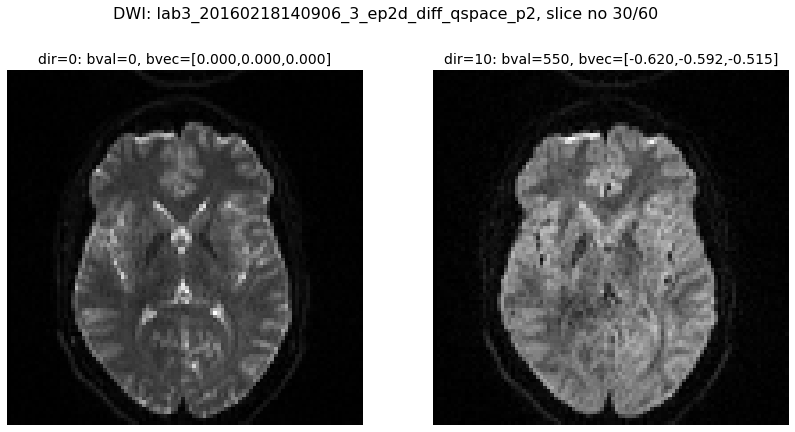

In [10]:
# Inspect data

plt.rcParams["figure.figsize"] = (14,7)

b1 = 0
b2 = 10
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, b1].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b1, bvals[b1], bvecs[b1][0],bvecs[b1][1], bvecs[b1][2]), size=14)
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, b2].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b2, bvals[b2], bvecs[b2][0],bvecs[b2][1], bvecs[b2][2]), size=14)
plt.suptitle('DWI: %s, slice no %d/%d' % (dwifn, axial_middle, data.shape[2]), size=16)
plt.savefig('./assets/Lab3_LG_Prisma_20160218_dipy_data.png', bbox_inches='tight')
plt.show()

In DIPY, we use an object called `GradientTable` which holds all the acquisition specific parameters, e.g. b-values, b-vectors, timings and others. 

In [11]:
gtab = gradient_table(bvals, bvecs)

In [12]:
print(gtab.bvals)

[   0.  200.  200.  200.  400.  350.  400.  400.  400.  350.  550.  550.
  550.  550.  750.  750.  750.  950.  950.  950.  950.  950.  950.  950.
  950.  950.  950.  950.  950. 1100. 1100. 1150. 1100. 1100. 1150. 1150.
 1100. 1100. 1150. 1100. 1100. 1500. 1500. 1500. 1500. 1500. 1500. 1700.
 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1850. 1850. 1900. 1850. 1900. 1850. 1850. 1900. 1900. 1850.
 1850. 1850. 2050. 2050. 2050. 2050. 2050. 2050. 2050. 2050. 2050. 2050.
 2050. 2050. 2250. 2250. 2250. 2250. 2450. 2450. 2450. 2400. 2450. 2450.
 2450. 2450. 2450. 2400. 2450. 2450. 2600. 2600. 2600. 2600. 2650. 2600.
 2600. 2650. 2600. 2600. 2600. 2600. 2600. 2600. 2600. 2600. 2650. 2600.
 2600. 2650. 2600. 2600. 2600. 2600. 3000. 3000. 3000.]


In [13]:
# Display first 5 bvecs
print(gtab.bvecs[:5, :])

[[ 0.00000e+00  0.00000e+00  0.00000e+00]
 [-2.00991e-06 -1.00000e+00 -2.49706e-05]
 [-7.46485e-02 -2.11623e-02 -9.96985e-01]
 [ 9.97159e-01 -1.06073e-02 -7.45820e-02]
 [-7.00890e-01 -7.10899e-01  5.81085e-02]]


`gtab.b0s_mask` can be used to tell what part of the data is the S0 volumes (volumes which correspond to b-values of 0)

In [14]:
S0s = data[:, :, :, gtab.b0s_mask]

In [15]:
print(S0s.shape)
print(S0s.shape[-1])

(100, 100, 60, 1)
1


We save this in a new NIFTI file in the `results` directory

In [16]:
fnS0s = join(rname, '%s_dwi_S0.nii.gz' % dwifn)
save_nifti(fnS0s, S0s, affine)

## Define function `extract_S0s`

In [17]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.io.image import save_nifti

def extract_S0s(inpdir, dwifn, outdir):
    """
    Extract S0s from dwi file
    Usage:
    Ex: 
    """
    
    fdwi = join(inpdir, '%s.nii.gz' % dwifn)
    #print(fdwi)
    fbval = join(inpdir, '%s.bval' % dwifn)
    fbvec = join(inpdir, '%s.bvec' % dwifn)
    
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    data, affine, img = load_nifti(fdwi, return_img=True)
    S0s = data[:, :, :, gtab.b0s_mask]
    nS0s = S0s.shape[-1]
    
    fnS0s = join(outdir, '%s_dwi_S0.nii.gz' % dwifn)
    save_nifti(fnS0s, S0s, affine)
    
    return S0s, affine, nS0s

In [18]:
# Testing function for single subject, single examination

S0s, affine, nS0s = extract_S0s(dname, dwifn, rname)
print('affine:\n', affine)
print('nS0s:', nS0s)

affine:
 [[-2.19293380e+00  8.67084715e-09  1.76185533e-01  1.06019615e+02]
 [-2.77641532e-03  2.19972682e+00 -3.45574021e-02 -7.04481506e+01]
 [ 1.76163644e-01  3.46687585e-02  2.19266152e+00 -4.71965027e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
nS0s: 1


In [19]:
# In case number of S0 images is > 1, we will take the mean
S0s_mean = S0s.mean(axis=-1)
nS0s = S0s.shape[-1]
print('S0s.shape:', S0s.shape)
print('S0s_mean.shape:', S0s_mean.shape)
print('nS0s:', nS0s)

fnS0s_mean = join(rname, '%s_dwi_S0_mean_of_%d.nii.gz' % (dwifn, nS0s))
# save_nifti(fnS0s_mean, S0s_mean, affine)   Not relevant to save in outr case with nS0s = 1

S0s.shape: (100, 100, 60, 1)
S0s_mean.shape: (100, 100, 60)
nS0s: 1


In [20]:
# !freeview -v ./data/Lab3_LG_Prisma_20160218_dipy_results/lab3_20160218140906_3_ep2d_diff_qspace_p2_dwi_S0.nii.gz